# Get Image from given GIS data

+ Read shp file from ../Rawdata
+ Overlay layers according to color
+ Extract images by 128 by 128

In [89]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from PIL import Image

In [ ]:
path = '../Rawdata/'
#EMD = path + 'juso/11000/TL_SCCO_EMD.shp'
#Parcel = path + 'Boundary/Fixed_boundary.shp'
#Landuse = path + 'LandUse/Total_Landuse.shp'
#Building = path + 'juso/11000/TL_SPBD_BULD.shp'
#Road = path + 'juso/11000/TL_SPRD_RW.shp'

In [ ]:
Sample_path = '../Rawdata/Sample/'
EMD = Sample_path + 'Sample_EMD.shp'
Block = Sample_path + 'Sample_Boundary.shp'
Parcel = Sample_path + 'Sample_Parcel_2.shp'
Landuse = Sample_path + 'Sample_Landuse.shp'
Building = Sample_path + 'Sample_BULD.shp'
Road = Sample_path + 'Sample_RW.shp'
#Block = Sample_path + 'Sample_Block.shp'


In [ ]:
#Read File
EMD_gdf = gpd.read_file(EMD)
Parcel_gdf = gpd.read_file(Parcel)
Landuse_gdf = gpd.read_file(Landuse)
Building_gdf = gpd.read_file(Building)
Road_gdf = gpd.read_file(Road)
Block_gdf = gpd.read_file(Block)

EMD_gdf = EMD_gdf.to_crs(epsg = 5179)
Parcel_gdf = Parcel_gdf.to_crs(epsg = 5179)
Landuse_gdf = Landuse_gdf.to_crs(epsg = 5179)
Building_gdf =  Building_gdf.to_crs(epsg = 5179)
Road_gdf =  Road_gdf.to_crs(epsg = 5179)
Block_gdf = Block_gdf.to_crs(epsg = 5179)

In [ ]:

ColorCode = {'UQA110': [245,245,7, '#F5F507'],
             'UQA111': [237, 248, 91, '#EDF85B'],
             'UQA112': [222, 237, 36, '#DEED24'],
             'UQA120': [248, 255, 105, '#F8FF69'],
             'UQA121': [247, 238, 48, '#F7EE30'],
             'UQA122': [252, 221, 43, '#FCDD2B'],
             'UQA123': [245, 203, 31, '#F5CB1F'],
             'UQA124': [245, 203, 31, '#F5CB1F'],
             'UQA130': [220, 168, 7, '#DCA807'],
             'UQA210': [211, 107, 66, '#D36B42'],
             'UQA220': [231, 153, 107, '#E7996B'],
             'UQA230': [241, 182, 140, '#F1B68C'],
             'UQA240': [253, 213, 172, '#FDD5AC'],
             'UQA330': [169, 169, 255, '#A9A9FF'],
             'UQA410': [157, 147, 79, '#9D934F'],
             'UQA420': [116, 215, 83, '#74D753'],
             'UQA430': [96, 202, 96, '#60CA60'],
             'UQA999': [169, 169, 169, '#A9A9A9']}
ColorCode_RGB = {k: v[:3] for k, v in ColorCode.items()}
ColorCode_16 = {k: v[-1] for k, v in ColorCode.items()}
print(ColorCode_16)

In [ ]:
# Add Color dictionary in Landuse
Landuse_gdf['color'] = Landuse_gdf['CODE']
Landuse_gdf = Landuse_gdf.replace({'color': ColorCode_16})

In [ ]:

def trim_layer(boundary, target):
    '''
    Trim given target layer according to the boundary layer
    Input: GeoDataFrame, GeoDataFrame / Output: GeoDataFrame
    '''
    trimmed_layer = gpd.overlay(boundary, target)
    return trimmed_layer

trimmed_layer = trim_layer(Block_gdf, Road_gdf)
trimmed_layer.plot()


In [ ]:
# Get trimmed layer by every district
def get_districts(boundary, target):
    '''
    Trim Every layers by Dong
    Input: GeoDataFrame, GeoDataFrame / Output: List of GeoDataFrame
    '''
    trimmed_layers = []
    for k, v in boundary.iterrows():
        p1 = v.geometry
        g = gpd.GeoSeries([p1])
        gdf = gpd.GeoDataFrame(crs = 'EPSG:5179', geometry = g)
        temp = trim_layer(gdf, target)
        trimmed_layers.append(temp)
    return trimmed_layers
trimmed_LUs = get_districts(Block_gdf, Landuse_gdf)
trimmed_RWs = get_districts(Block_gdf, Road_gdf)
trimmed_PCLs = get_districts(Block_gdf, Parcel_gdf)
trimmed_BULDs = get_districts(Block_gdf, Building_gdf)
#trimmed_BLKs = get_districts(EMD_gdf, Block_gdf)

In [ ]:
#trimmed_LUs[0].plot()
#plt.show()
Block_gdf


In [ ]:
# Give Color code on land use
def useColorcode(target_list):
    '''
    Apply color code on land use gdf to export img
    Input: List of List of GeoDataFrame  / Output: png
    '''
    LUs, RWs, PCLs, BULDs, BLKs = target_list
    n = len(BLKs)
    print(n)
    my_dpi = 96
    for i in range(n):
        fig, ax = plt.subplots(figsize = (512/my_dpi, 512/my_dpi), dpi = my_dpi)
        ax.set_axis_off()
        ax.set_aspect('equal')
        LUs[i].plot(ax = ax, color = LUs[i]['color'])
        PCLs[i].plot(ax = ax, facecolor = 'none', edgecolor = 'black', lw = 0.1)
        #BLKs[i].plot(ax = ax, facecolor = 'none', edgecolor = 'white', lw = 0.2)
        RWs[i].plot(ax = ax, color = 'gray')
        
        plt.show()
        fig_name = './tmp/sample_{}'.format(str(i))
        fig.savefig(fig_name)
    return 0
useColorcode([trimmed_LUs, trimmed_RWs, trimmed_PCLs, trimmed_BULDs, Block_gdf])

In [121]:
# Join building height to parcel
def parcel_height(parcels, buildings):
    '''
    Join average building height (floor) by matching parcel
    Input: List of GeoDataFrame, List of GeoDataFrame / Output: List of GeoDataFrame
    '''
    parcel_Hs = []
    for i in range(len(parcels)):
        parcel = parcels[i]
        building = buildings[i]
        building_h = building[['GRO_FLO_CO', 'geometry']]
        parcel_h = gpd.sjoin(parcel, building_h, how = 'left')
        parcel_meanH = parcel_h.groupby('PNU').mean()
        parcel_H = parcel.merge(parcel_meanH, on = 'PNU')
        parcel_H['GRO_FLO_CO'].fillna(0, inplace = True)
        parcel_Hs.append(parcel_H)
    return parcel_Hs

PCL_Hs = parcel_height(trimmed_PCLs, trimmed_BULDs)
print(len(PCL_Hs))
print(PCL_Hs[0]['GRO_FLO_CO'])


65
0      2.000000
1      0.000000
2      0.000000
3      0.000000
4      3.000000
         ...   
356    1.000000
357    2.666667
358    1.666667
359    2.000000
360    2.000000
Name: GRO_FLO_CO, Length: 361, dtype: float64


<ipython-input-142-e6a517d6ee2f>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (512/my_dpi, 512/my_dpi), dpi = my_dpi)


,PNU,JIBUN,BCHK,SGG_OID_x,COL_ADM_SE,CODE,geometry,SGG_OID_y,index_right,GRO_FLO_CO,color
0,1121510700100180027,18-27��,1,99632,11215,UQA130,"POLYGON ((961934.975 1949959.364, 961931.927 1...",99632,NaN,0.0,"(0.09803921568627451, 0, 0)"
1,1121510900103550009,355-9 ��,1,110561,11215,UQA130,"MULTIPOLYGON (((961935.057 1949959.737, 961934...",110561,NaN,0.0,"(0.09803921568627451, 0, 0)"
2,1121510700100180028,18-28 ��,1,222641,11215,UQA130,"POLYGON ((961931.805 1949945.131, 961908.026 1...",222641,47.5,2.0,"(0.09803921568627451, 0, 0)"
3,1121510700100210001,21-1��,1,99636,11215,UQA123,"POLYGON ((961899.547 1949950.499, 961900.419 1...",99636,20.0,3.0,"(0.19607843137254902, 0, 0)"
4,1121510700100200026,20-26��,1,100006,11215,UQA122,"POLYGON ((961828.914 1949799.592, 961820.674 1...",100006,48.5,1.0,"(0.09803921568627451, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...
120,1121510700100180037,18-37 ��,1,222657,11215,UQA124,"POLYGON ((961839.014 1949850.656, 961823.215 1...",222657,NaN,0.0,"(0.09803921568627451, 0, 0)"
121,1121510700100180038,18-38 ��,1,222658,11215,UQA124,"POLYGON ((961823.215 1949857.962, 961839.014 1...",222658,NaN,0.0,"(0.09803921568627451, 0, 0)"
122,1121510700100210065,21-65 ��,1,210756,11215,UQA124,"POLYGON ((961789.106 1949923.477, 961788.611 1...",210756,NaN,0.0,"(0.09803921568627451, 0, 0)"
123,1121510700100210062,21-62 ��,1,210753,11215,UQA124,"POLYGON ((961793.912 1949934.138, 961793.345 1...",210753,NaN,0.0,"(0.09803921568627451, 0, 0)"


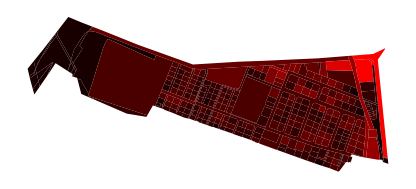

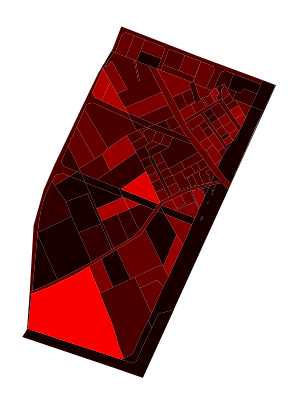

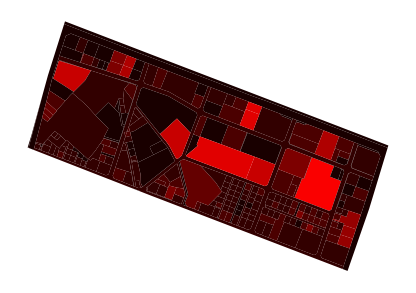

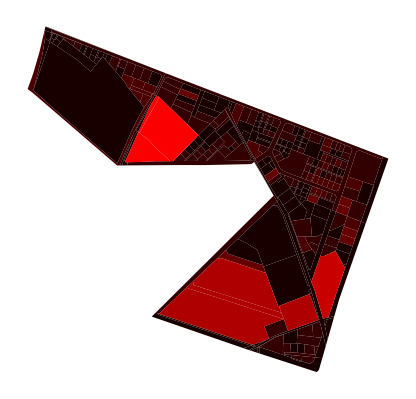

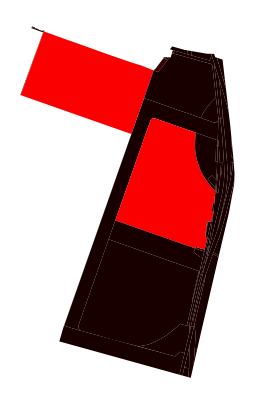

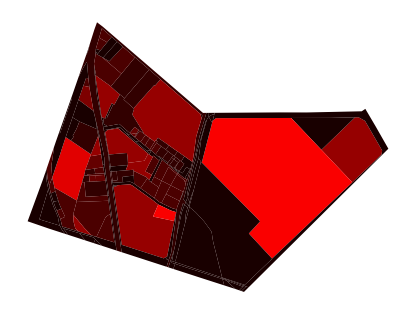

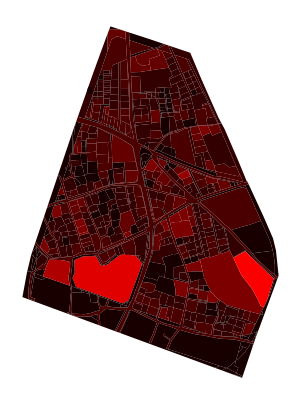

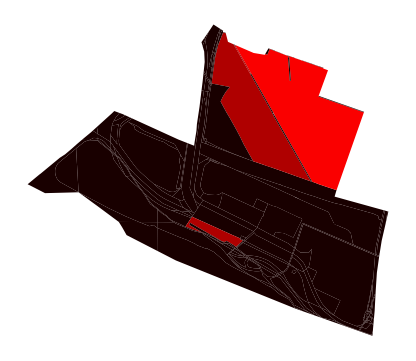

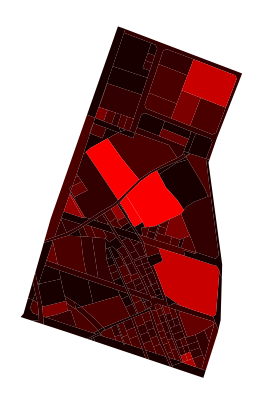

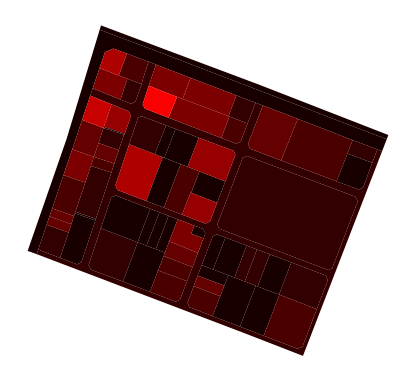

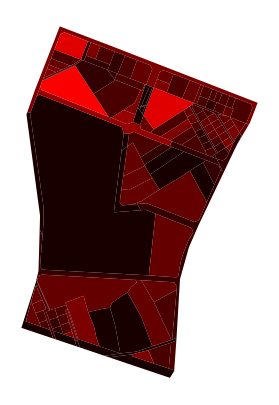

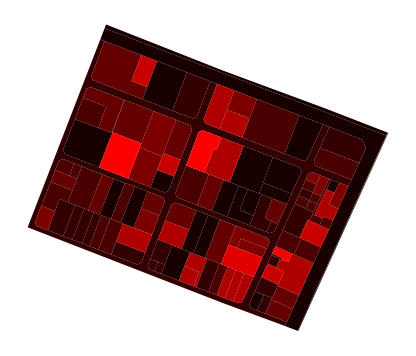

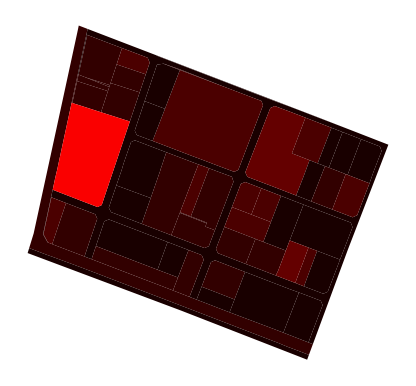

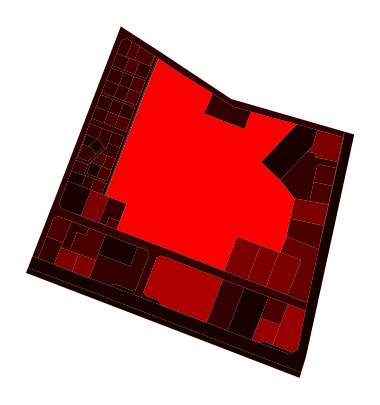

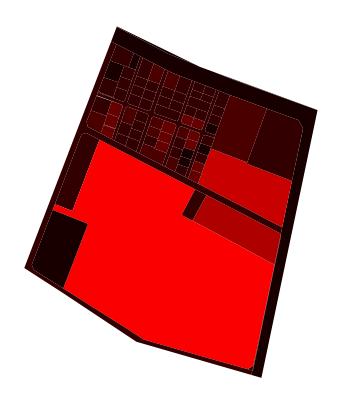

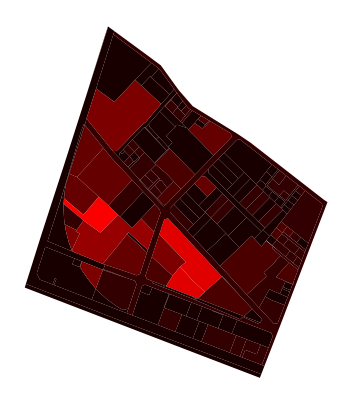

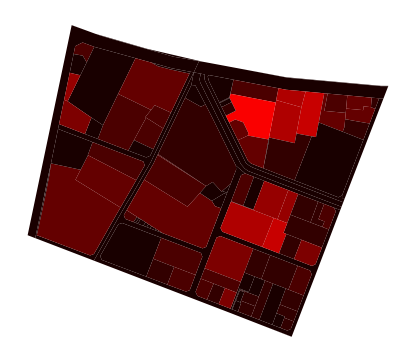

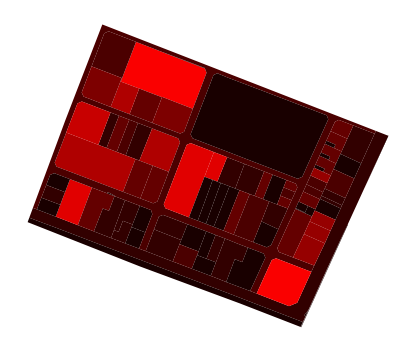

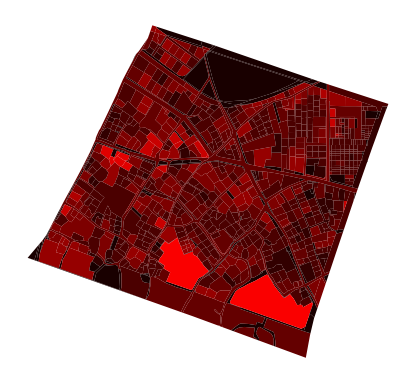

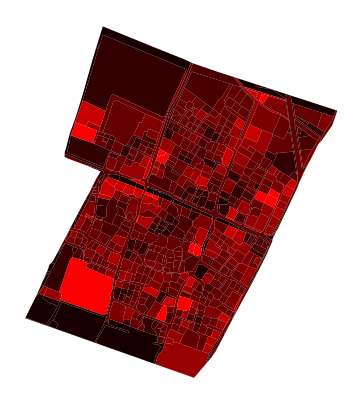

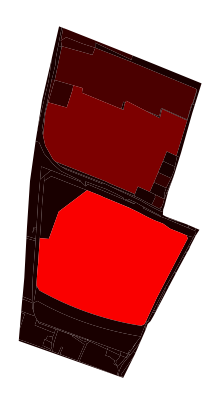

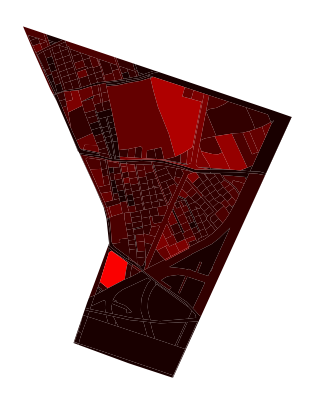

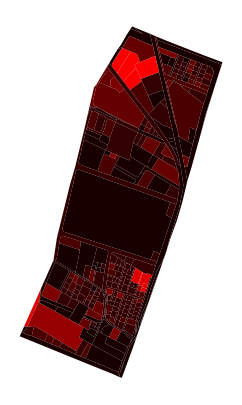

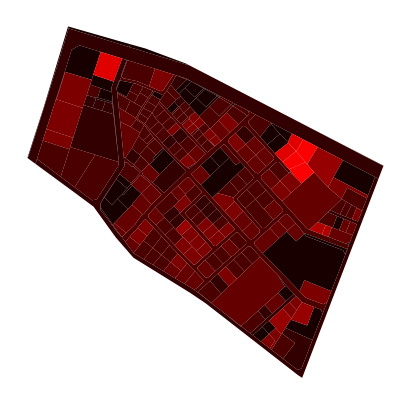

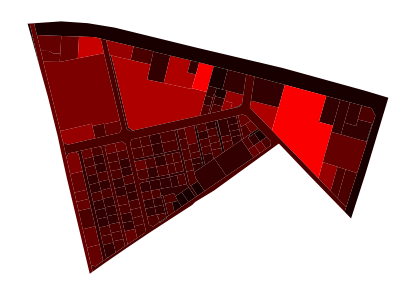

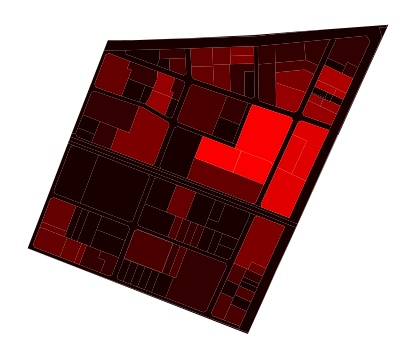

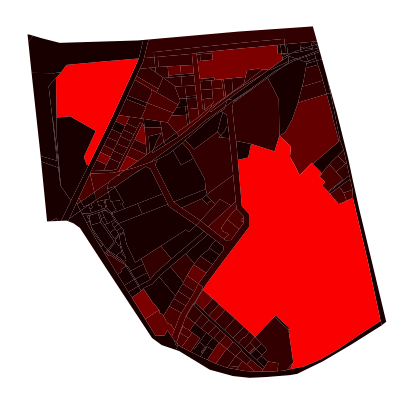

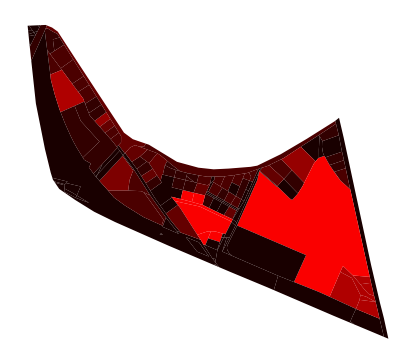

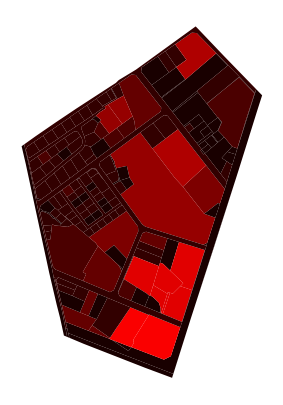

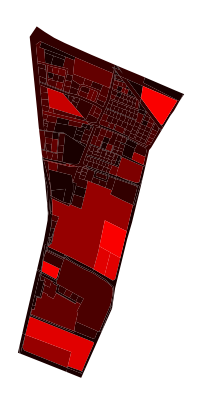

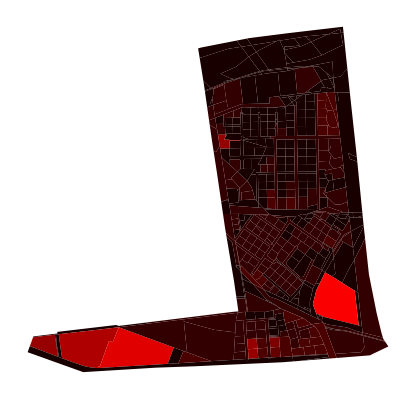

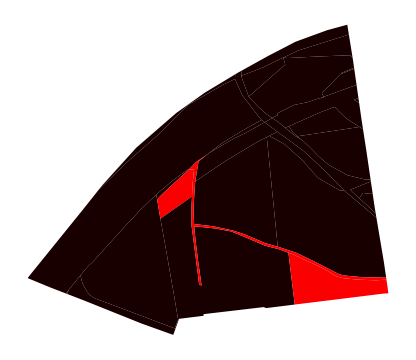

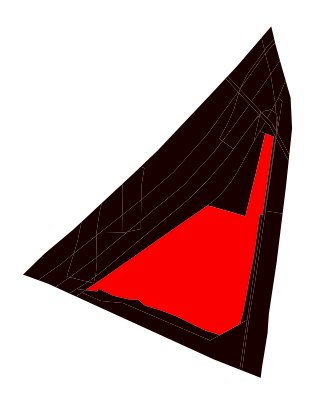

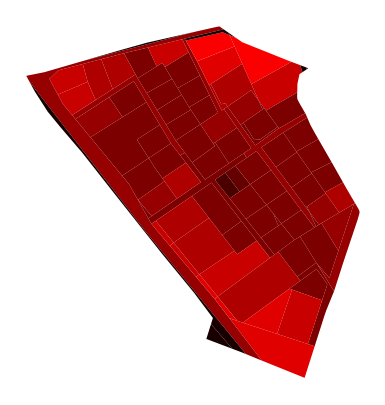

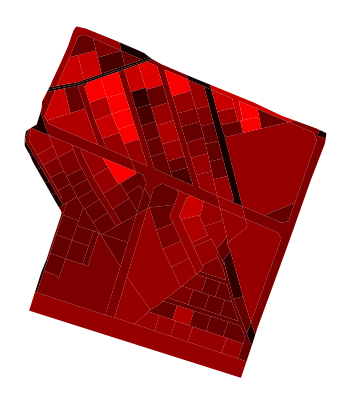

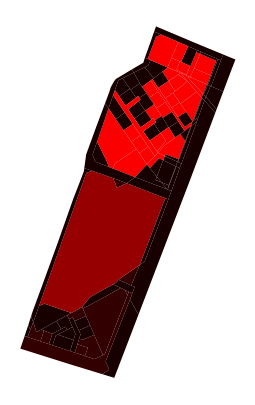

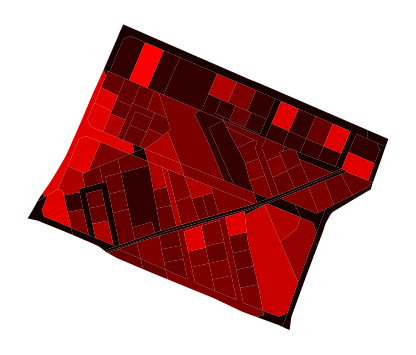

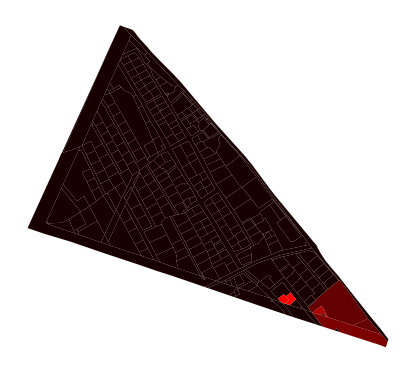

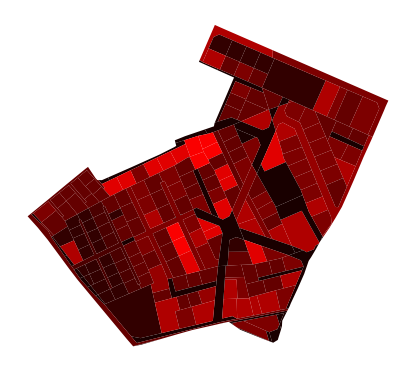

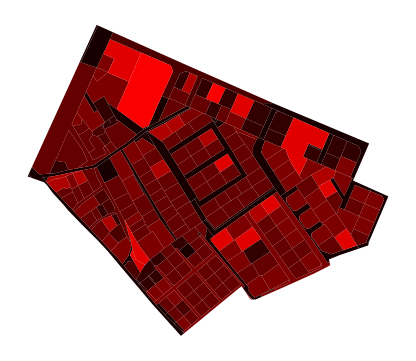

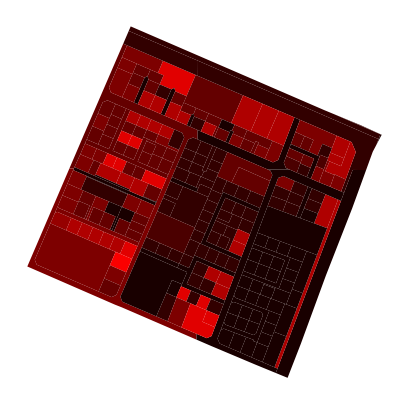

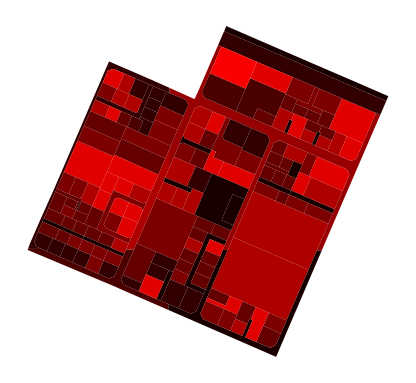

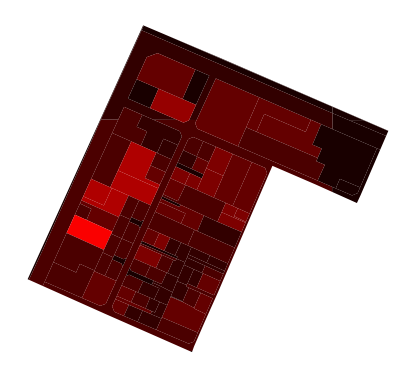

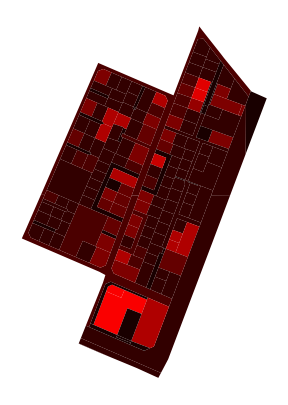

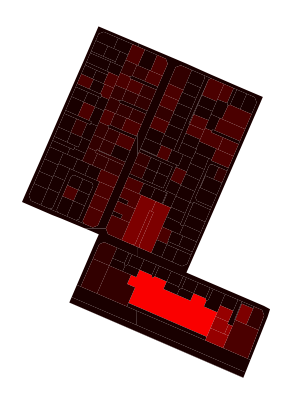

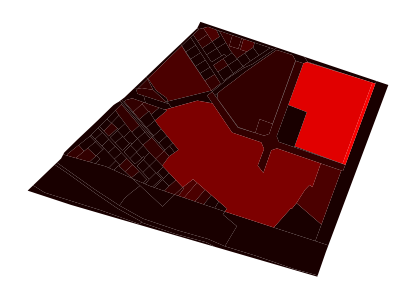

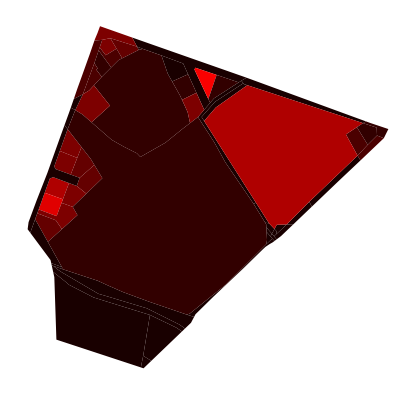

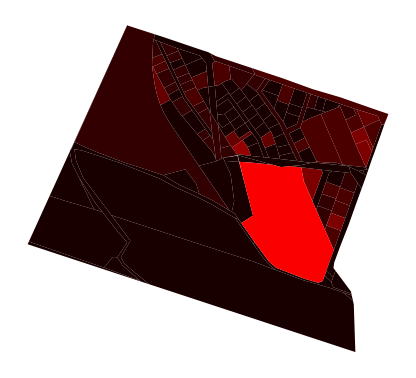

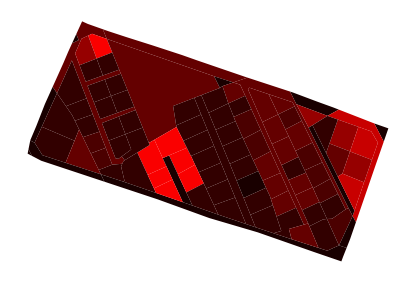

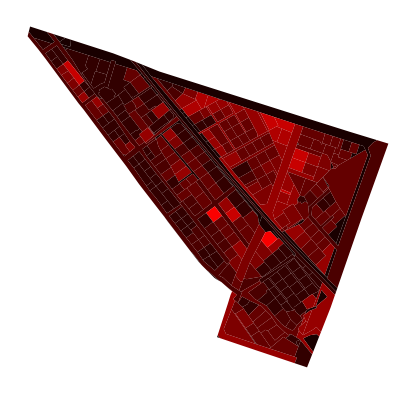

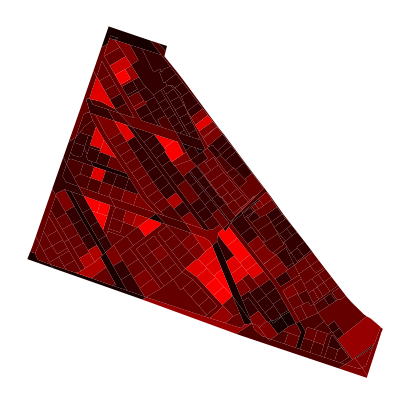

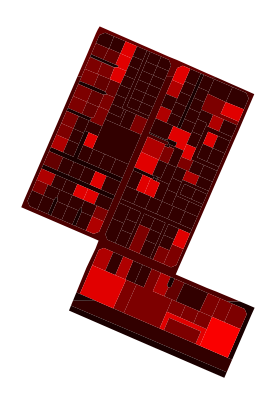

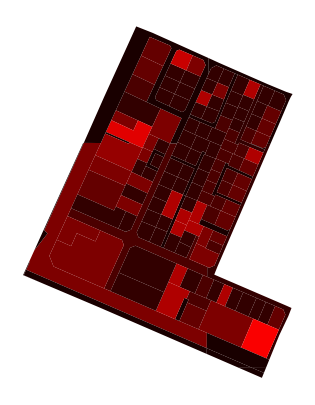

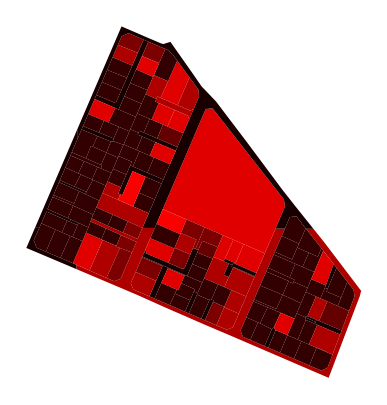

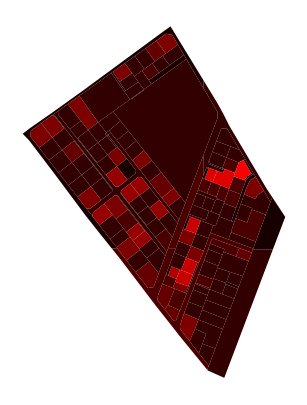

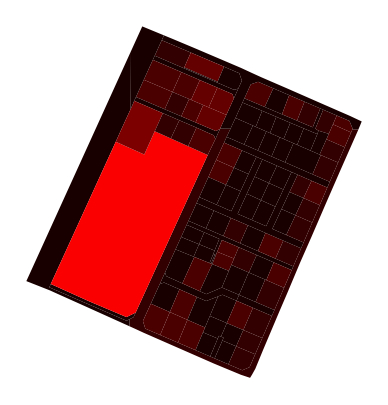

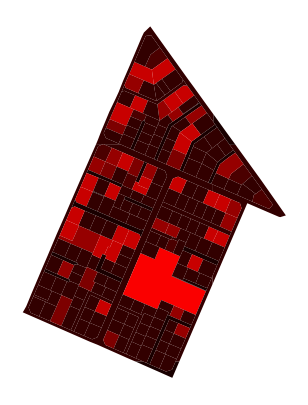

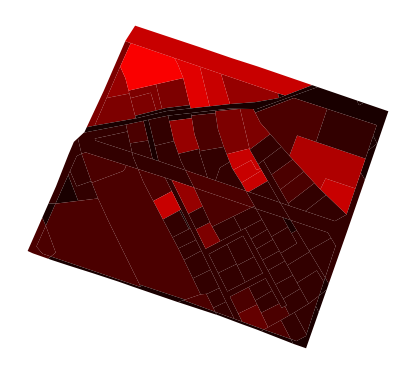

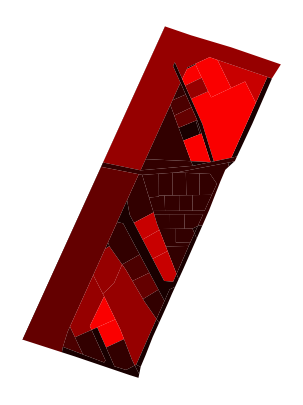

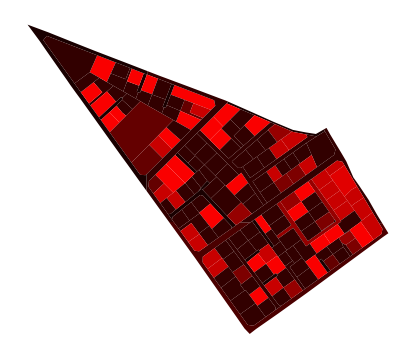

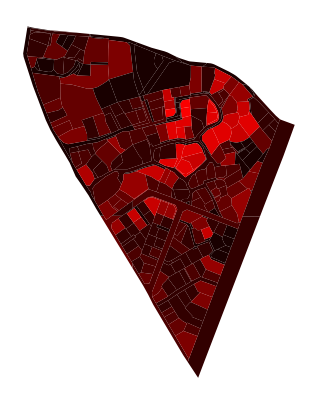

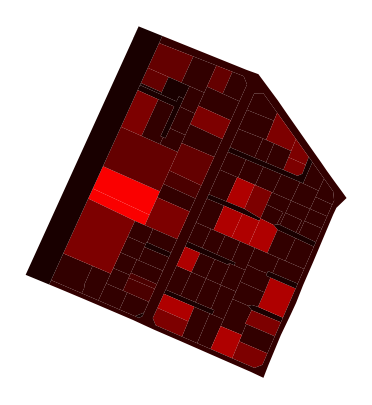

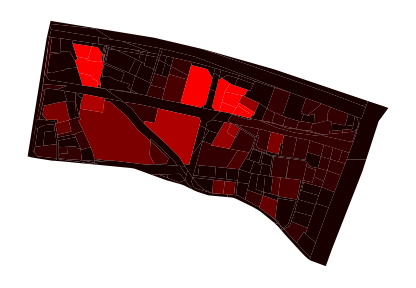

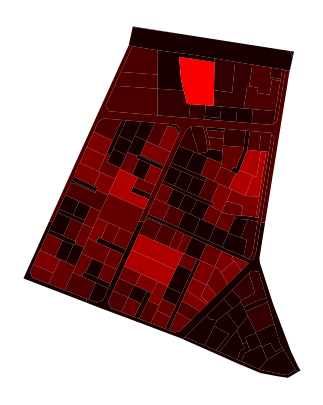

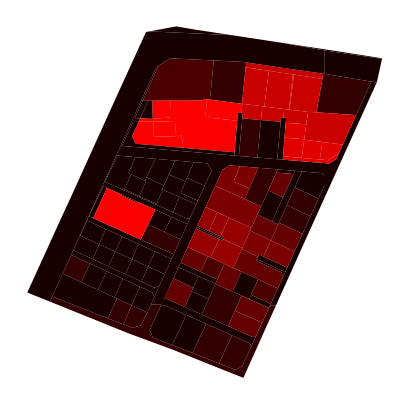

In [142]:
# Parcel to color
h_colorcode = [(25/255, 0, 0), (50/255, 0, 0), (75/255, 0, 0), (100/255, 0, 0), (125/255, 0, 0),
               (150/255, 0, 0), (175/255, 0, 0), (200/255, 0, 0), (225/255, 0, 0), (250/255, 0, 0)]
plt.close()
def parcel_Hcolor(parcels):
    '''
    Give RGB gradation according to the parcel's height
    Input: List of GeoDataFrame / Output: List of imgs
    '''
    for i in range(len(parcels)):
        parcel = parcels[i]
        parcel['color'] = pd.cut(parcel['GRO_FLO_CO'], bins = 10, labels = h_colorcode, include_lowest = True)
        #parcel['color'].replace(0, (0, 1,1), inplace = True)
        my_dpi = 96
        fig, ax = plt.subplots(figsize = (512/my_dpi, 512/my_dpi), dpi = my_dpi)
        ax.set_axis_off()
        parcel.plot(ax = ax, color = parcel['color'], edgecolor = 'None')
        fig_name = './tmp_bld/sample_building_{}'.format(str(i))
        fig.savefig(fig_name)
    return parcel
parcel_Hcolor(PCL_Hs)

In [ ]:
# Color to height by pixel


In [ ]:
# Give Style
plt.ioff()
EMD_gdf.plot()
plt.savefig('./img/EMD.png')
plt.close()

In [ ]:
EMD_gdf.plot()